In [12]:
import os
import tarfile
from mxnet import gluon

data_root = '../data'
voc_root = data_root + '/VOCdevkit/VOC2012'
url = ('http://host.robots.ox.ac.uk/pascal/VOC/voc2012'
       '/VOCtrainval_11-May-2012.tar')
sha1 = '4e443f8a2eca6b1dac8a6c57641b67dd40621a49'

# fname = gluon.utils.download(url, data_root, sha1_hash=sha1)

# if not os.path.isfile(voc_root+'/ImageSets/Segmentation/train.txt'):
#     with tarfile.open(fname, 'r') as f:
#         f.extractall(data_root)

In [13]:
from mxnet import image

def read_images(root=voc_root, train=True):
    txt_fname = root + '/ImageSets/Segmentation/' + (
        'train.txt' if train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    n = len(images)
    data, label = [None] * n, [None] * n
    for i, fname in enumerate(images):
        data[i] = image.imread('%s/JPEGImages/%s.jpg' % (
            root, fname))
        label[i] = image.imread('%s/SegmentationClass/%s.png' % (
            root, fname))
    return data, label

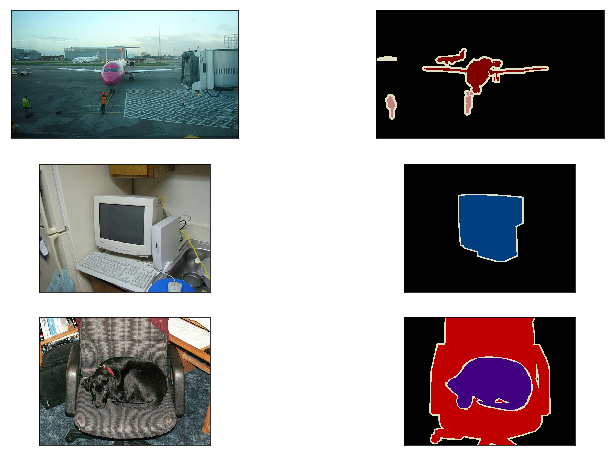

[(281, 500, 3),
 (281, 500, 3),
 (375, 500, 3),
 (375, 500, 3),
 (375, 500, 3),
 (375, 500, 3)]

In [14]:
import cv2 # tested with 3.1.0 version
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('..')
import utils

train_images, train_labels = read_images()

imgs = []
for i in range(3):
    imgs += [train_images[i], train_labels[i]]

utils.show_images(imgs, nrows=3, ncols=2, figsize=(12,8))
[im.shape for im in imgs]

(281, 500, 3)


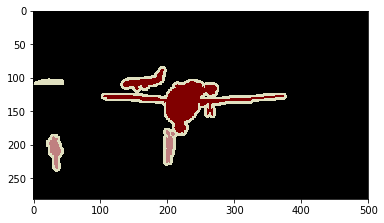

In [45]:
print (train_labels[0].shape)
imgs = train_labels[0]
plt.imshow(imgs.asnumpy())

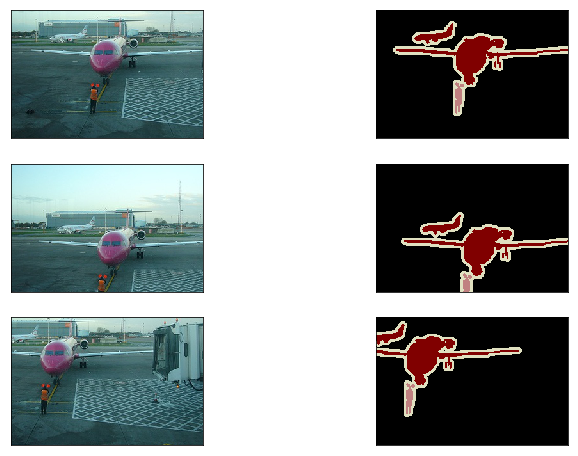

In [46]:
def rand_crop(data, label, height, width):
    data, rect = image.random_crop(data, (width, height))
    label = image.fixed_crop(label, *rect)
    return data, label

imgs = []
for _ in range(3):
    imgs += rand_crop(train_images[0], train_labels[0],
                      200, 300)

utils.show_images(imgs, nrows=3, ncols=2, figsize=(12,8))

In [47]:
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']
# RGB color for each class
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

len(classes), len(colormap)

(21, 21)

In [54]:
import numpy as np
from mxnet import nd

cm2lbl = np.zeros(256**3)
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i

def image2label(im):
    data = im.astype('int32').asnumpy()
    idx = (data[:,:,0]*256+data[:,:,1])*256+data[:,:,2]
    return nd.array(cm2lbl[idx])

In [63]:
y = image2label(train_labels[0])
y[105:115, 130:140]


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
<NDArray 10x10 @cpu(0)>

In [64]:
from mxnet import gluon
from mxnet import nd


rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

def normalize_image(data):
    return (data.astype('float32') / 255 - rgb_mean) / rgb_std

class VOCSegDataset(gluon.data.Dataset):

    def _filter(self, images):
        return [im for im in images if (
            im.shape[0] >= self.crop_size[0] and
            im.shape[1] >= self.crop_size[1])]

    def __init__(self, train, crop_size):
        self.crop_size = crop_size
        data, label = read_images(train=train)
        data = self._filter(data)
        self.data = [normalize_image(im) for im in data]
        self.label = self._filter(label)
        print('Read '+str(len(self.data))+' examples')

    def __getitem__(self, idx):
        data, label = rand_crop(
            self.data[idx], self.label[idx],
            *self.crop_size)
        data = data.transpose((2,0,1))
        label = image2label(label)
        return data, label

    def __len__(self):
        return len(self.data)

In [65]:
# height x width
input_shape = (320, 480)
voc_train = VOCSegDataset(True, input_shape)
voc_test = VOCSegDataset(False, input_shape)

Read 1114 examples
Read 1078 examples


In [72]:
batch_size = 64
train_data = gluon.data.DataLoader(
    voc_train, batch_size, shuffle=True,last_batch='discard')
test_data = gluon.data.DataLoader(
    voc_test, batch_size,last_batch='discard')

for data, label in train_data:
    print(data.shape)
    print(label.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)


In [73]:
from mxnet.gluon import nn

conv = nn.Conv2D(10, kernel_size=4, padding=1, strides=2)
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)

conv.initialize()
conv_trans.initialize()

x = nd.random.uniform(shape=(1,3,64,64))
y = conv(x)
print('Input:', x.shape)
print('After conv:', y.shape)
print('After transposed conv', conv_trans(y).shape)

Input: (1, 3, 64, 64)
After conv: (1, 10, 32, 32)
After transposed conv (1, 3, 64, 64)


In [74]:
from mxnet.gluon.model_zoo import vision as models
pretrained_net = models.resnet18_v2(pretrained=True)

(pretrained_net.features[-4:], pretrained_net.output)

Model file is not found. Downloading.


(HybridSequential(
   (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512)
   (1): Activation(relu)
   (2): GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True)
   (3): Flatten
 ), Dense(512 -> 1000, linear))

In [75]:
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)

x = nd.random.uniform(shape=(1,3,*input_shape))
print('Input:', x.shape)
print('Output:', net(x).shape)

Input: (1, 3, 320, 480)
Output: (1, 512, 10, 15)


In [76]:
num_classes = len(classes)

with net.name_scope():
    net.add(
        nn.Conv2D(num_classes, kernel_size=1),
        nn.Conv2DTranspose(num_classes, kernel_size=64, padding=16,strides=32)
    )

In [77]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros(
        (in_channels, out_channels, kernel_size, kernel_size),
        dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return nd.array(weight)

## Try Conv2D bilinear_kernel Transpose 

Input (281, 500, 3)
Output (1124, 2000, 3)


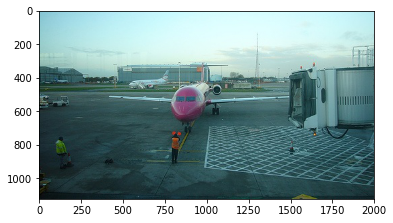

In [78]:
from matplotlib import pyplot as plt

x = train_images[0]
print('Input', x.shape)
x = x.astype('float32').transpose((2,0,1)).expand_dims(axis=0)/255

conv_trans = nn.Conv2DTranspose(
    3, in_channels=3, kernel_size=8, padding=2, strides=4)
conv_trans.initialize()
conv_trans(x)
conv_trans.weight.set_data(bilinear_kernel(3, 3, 8))


y = conv_trans(x)
y = y[0].clip(0,1).transpose((1,2,0))
print('Output', y.shape)

plt.imshow(y.asnumpy())
plt.show()

In [79]:
#initiallize
from mxnet import init

conv_trans = net[-1]
conv_trans.initialize(init=init.Zero())
net[-2].initialize(init=init.Xavier())

x = nd.zeros((batch_size, 3, *input_shape))
net(x)

shape = conv_trans.weight.data().shape
conv_trans.weight.set_data(bilinear_kernel(*shape[0:3]))


In [80]:
import sys
sys.path.append('..')
import utils

loss = gluon.loss.SoftmaxCrossEntropyLoss(axis=1)

ctx = utils.try_all_gpus()
net.collect_params().reset_ctx(ctx)

trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': .1, 'wd':1e-3})

utils.train(train_data, test_data, net, loss,
            trainer, ctx, num_epochs=10)

Start training on  [cpu(0)]
Epoch 0. Loss: 1.541, Train acc 0.72, Test acc 0.79, Time 1691.4 sec
Epoch 1. Loss: 0.596, Train acc 0.83, Test acc 0.83, Time 1772.1 sec
Epoch 2. Loss: 0.447, Train acc 0.86, Test acc 0.84, Time 1805.6 sec
Epoch 3. Loss: 0.378, Train acc 0.88, Test acc 0.83, Time 1638.5 sec
Epoch 4. Loss: 0.319, Train acc 0.89, Test acc 0.82, Time 1625.5 sec
Epoch 5. Loss: 0.300, Train acc 0.90, Test acc 0.84, Time 1624.2 sec
Epoch 6. Loss: 0.277, Train acc 0.91, Test acc 0.85, Time 1628.2 sec
Epoch 7. Loss: 0.247, Train acc 0.92, Test acc 0.85, Time 1617.4 sec
Epoch 8. Loss: 0.226, Train acc 0.92, Test acc 0.85, Time 1630.9 sec
Epoch 9. Loss: 0.219, Train acc 0.92, Test acc 0.85, Time 1624.1 sec


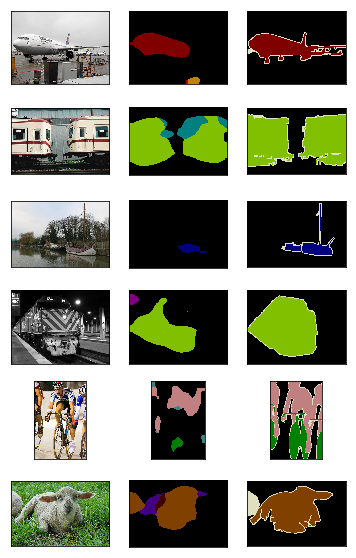

In [81]:
def predict(im):
    data = normalize_image(im)
    data = data.transpose((2,0,1)).expand_dims(axis=0)
    yhat = net(data.as_in_context(ctx[0]))
    pred = nd.argmax(yhat, axis=1)
    return pred.reshape((pred.shape[1], pred.shape[2]))

def label2image(pred):
    x = pred.astype('int32').asnumpy()
    cm = nd.array(colormap).astype('uint8')
    return nd.array(cm[x,:])

test_images, test_labels = read_images(train=False)

n = 6
imgs = []
for i in range(n):
    x = test_images[i]
    pred = label2image(predict(x))
    imgs += [x, pred, test_labels[i]]

utils.show_images(imgs, nrows=n, ncols=3, figsize=(6,10))


In [53]:
# l=np.zeros(100)
# for i in range(100):
#     l[i] = i*i
# l[np.array([[1,2],[3,4]])]

    

array([[ 1.,  4.],
       [ 9., 16.]])